# Notebook - Fractopo – KB11 Fracture Network Analysis

`fractopo` enables fast and scalable analysis of two-dimensional georeferenced fracture and lineament datasets. These are typically created with remote sensing using a variety of background materials: fractures can be extracted from outcrop orthomosaics and lineaments from digital elevation models (DEMs). Collectively both lineament and fracture datasets can be referred to as *trace* datasets or as *fracture networks*.

`fractopo` implements suggestions for structural geological studies by [Peacock and Sanderson (2018)](https://doi.org/10.1016/j.earscirev.2018.06.006):

>   **Basic geological descriptions should be followed by measuring their
   geometries and topologies, understanding their age relationships,**
   kinematic and mechanics, and developing a realistic, data-led model
   for related fluid flow.

`fractopo` characterizes the individual and overall geometry and topology of fractures and the fracture network. Furthermore the age relations are investigated with determined topological cross-cutting and abutting relationship between fracture sets.

Whether `fractopo` evolves to implement all the steps in the quote remains to be seen! The functionality grows as more use cases require implementation.

## Development imports (just skip to next heading, Data, if not interested!)

Avoid cluttering outputs with warnings.

In [1]:
import warnings

warnings.filterwarnings("ignore")

`geopandas` is the main module which `fractopo` is based on. It along with `shapely` and `pygeos` implement all spatial operations required for two-dimensional fracture network analysis. `geopandas` further implements all input-output operations like reading and writing spatial datasets (shapefiles, GeoPackages, GeoJSON, etc.).

In [2]:
import geopandas as gpd

`geopandas` uses `matplotlib` for visualizing spatial datasets.

In [3]:
import matplotlib.pyplot as plt

During local development the imports might be a bit messy as seen here. Not interesting for end-users.

In [4]:
# This cell's contents only for development purposes.
from importlib.util import find_spec

if find_spec("fractopo") is None:
    import sys

    sys.path.append("../../")

## Data

Fracture network data consists of georeferenced lineament or fracture traces, manually or automatically digitized, and a target area boundary that delineates the area in which fracture digiziting has been done. The boundary is important to handle edge effects in network analysis. `fractopo` only has a stub (and untested) implementation for cases where no target area is given so I strongly recommend to always delineate the traced fractures and pass the target area to `Network`.

`geopandas` is used to read and write spatial datasets. Here we use `geopandas` to both download and load trace and area datasets that are hosted on GitHub. A more typical case is that you have local files you wish to analyze in which case you can replace the url string with a path to the local file. E.g.

``` python
# Local trace data
trace_data_url = "~/data/traces.gpkg"
```

The example dataset here is from an island south of Loviisa, Finland. The island only consists of outcrop quite well polished by glaciations. The dataset is in `ETRS-TM35FIN` coordinate reference system.

In [5]:
# Trace and target area data available on GitHub
trace_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_traces.geojson"
area_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_area.geojson"

# Use geopandas to load data from urls
traces = gpd.read_file(trace_data_url)
area = gpd.read_file(area_data_url)

# Name the dataset
name = "KB11"

### Visualizing trace map data

`geopandas` has easy methods for plotting spatial data along with data coordinates. The plotting is based on `matplotlib`.

Text(0.5, 1.0, 'KB11, Coordinate Reference System = epsg:3067')

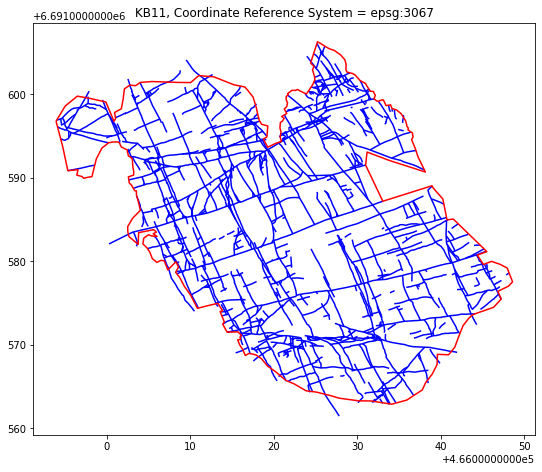

In [6]:
# Initialize the figure and ax in which data is plotted
fig, ax = plt.subplots(figsize=(9, 9))

# Plot the loaded trace dataset consisting of fracture traces.
traces.plot(ax=ax, color="blue")

# Plot the loaded area dataset that consists of a single polygon that delineates the traces.
area.boundary.plot(ax=ax, color="red")

# Give the figure a title
ax.set_title(f"{name}, Coordinate Reference System = {traces.crs}")

## Network

So far we have not used any `fractopo` functionality, just `geopandas`. Now we use the `Network` class to create `Network` instances that can be thought of as abstract representations of fracture networks. The fracture network contains traces and a target area boundary delineating the traces. 

To characterize the topology of a fracture network `fractopo` determines the topological branches and nodes ([Sanderson and Nixon 2015](https://doi.org/10.1016/j.jsg.2015.01.005)). 

-  Nodes consist of trace endpoints which can be isolated or snapped to end at another trace. 
-  Branches consist of every trace segment between the aforementioned nodes. 

Automatic determination of branches and nodes is determined with the `determine_branches_nodes` keyword. If given as `False`, they are not determined. You can still use the `Network` object to investigate geometric properties of just the traces.

`Network` initialization should be supplied with information regarding the trace dataset:

-  `truncate_traces`

    -  If you wish to only characterize the network within the target area boundary, the input traces should be cropped to the target area boundary. This is done when                  `truncate_traces` is given as `True.` `True` recommended.

-  `circular_target_area`

    -  If the target area is a circle `circular_target_area` should be given as `True`. A circular target area is recommended to avoid orientation bias in node counting.
   
-  `snap_threshold`

    -  To determine topological relationships between traces the abutments between traces should be snapped to some tolerance. This tolerance can be given here. E.g. when digitizing in QGIS with snapping turned on, the tolerance is probably much lower than even `0.001`. This represents the lowest distance between nodes that will be interpreted by `fractopo`. If you are doing millimetre scale or lower interpretations you might have to lower this value, otherwise `0.001` is probably fine.
    
    -  The trace validation functionality of `fractopo` can be (and should be) used to check that there are no topological errors within a certain tolerance.

In [7]:
# Import the Network class from fractopo
from fractopo.analysis.network import Network

In [8]:
# Create Network and automatically determine branches and nodes
# The Network instance is saved as kb11_network variable.
kb11_network = Network(
    traces,
    area,
    name=name,
    determine_branches_nodes=True,
    truncate_traces=True,
    circular_target_area=True,
    snap_threshold=0.001,
)

### Visualizing fracture network branches and nodes

We can similarly to the traces visualize the branches and nodes with `geopandas` plotting.

In [9]:
# Import identifier strings of topological branches and nodes
from fractopo.general import CC_branch, CI_branch, II_branch, X_node, Y_node, I_node

# Function to determine color for each branch and node type
def assign_colors(feature_type: str):
    if feature_type in (CC_branch, X_node):
        return "green"
    if feature_type in (CI_branch, Y_node):
        return "blue"
    if feature_type in (II_branch, I_node):
        return "black"
    return "red"

| Branch or Node Type | Color |
|---------------------|-------|
| C - C, X            | Green |
| C - I, Y            | Blue  |
| I - I, I            | Black |
| Other               | Red   |

#### Branches

<AxesSubplot:>

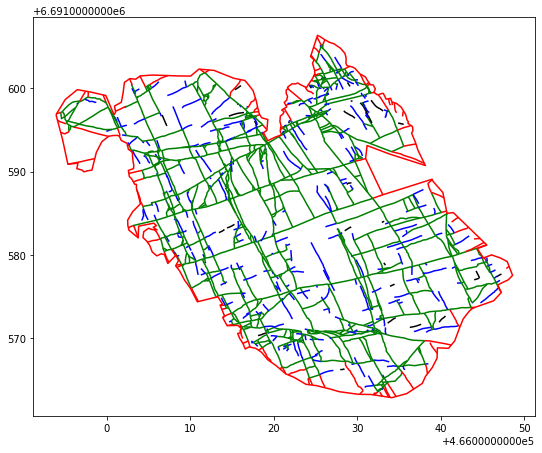

In [10]:
fix, ax = plt.subplots(figsize=(9, 9))
kb11_network.branch_gdf.plot(
    colors=[assign_colors(bt) for bt in kb11_network.branch_types], ax=ax
)
area.boundary.plot(ax=ax, color="red")

#### Nodes

<AxesSubplot:>

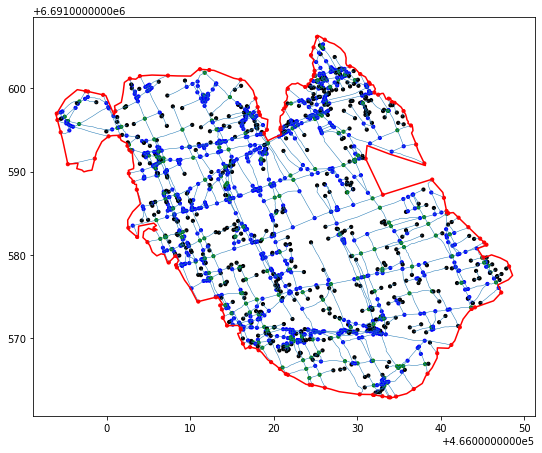

In [11]:
fix, ax = plt.subplots(figsize=(9, 9))
# Traces
kb11_network.trace_gdf.plot(ax=ax, linewidth=0.5)
# Nodes
kb11_network.node_gdf.plot(
    c=[assign_colors(bt) for bt in kb11_network.node_types], ax=ax, markersize=10
)
area.boundary.plot(ax=ax, color="red")

## Geometric Fracture Network Characterization

The most basic geometric properties of traces are their **length** and **orientation**. 

**Length** is the overall travel distance along the digitized trace. The length of traces individually is usually not interesting but the value **distribution** of all of the lengths is ([Bonnet et al. 2001](https://doi.org/10.1029/1999RG000074)). `fractopo` uses another Python package, `powerlaw`, for determining power-law, lognormal and exponential distribution fits. The wrapper around `powerlaw` is thin and therefore I urge you to see its [documentation](https://github.com/jeffalstott/powerlaw) and associated [article](https://doi.org/10.1371/journal.pone.0095816) for more info.

**Orientation** of a trace (or branch, or any line) can be defined in multiple ways that approach the same result when the line is **sublinear**:

-  Draw a straight line between the start and endpoints of the trace and calculate the orientation of that line. 

    -  This is the approach used in `fractopo`. Simple, but when the trace is curvy enough the simplification might be detrimental to analysis.
    
-  Plot each coordinate point of a trace and fit a linear regression trend line. Calculate the orientation of the trend line.

-  Calculate the orientation of each segment between coordinate points resulting in multiple orientation values for a single trace.

### Length distributions

#### Traces

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


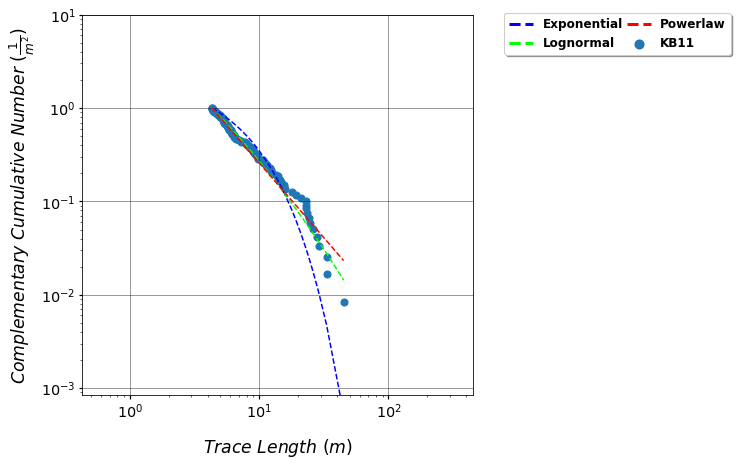

In [12]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture traces using powerlaw
fit, fig, ax = kb11_network.plot_trace_lengths()

In [13]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit.xmin}")
print(f"Powerlaw exponent: {fit.alpha - 1}")
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 4.321478841775524
Powerlaw exponent: 1.6051888040287916
Compare powerlaw fit to lognormal: R, p = (-0.6749942925041004, 0.4105159341196074)


#### Branches

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


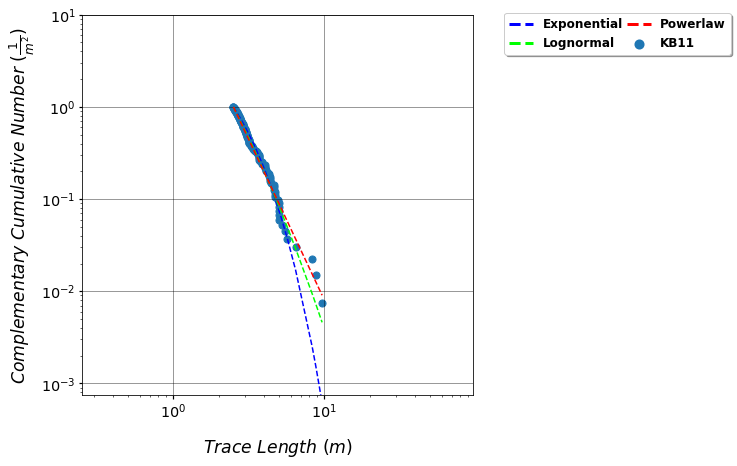

In [14]:
# Length distribution of branches
fit, fig, ax = kb11_network.plot_branch_lengths()

In [15]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit.xmin}")
print(f"Powerlaw exponent: {fit.alpha - 1}")
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 2.5085762872827186
Powerlaw exponent: 3.4758840889798854
Compare powerlaw fit to lognormal: R, p = (-0.48507539531630295, 0.5591241088263508)


### Rose plots

A rose plot is a histogram where the bars have been oriented based on pre-determined bins. `fractopo` rose plots are length-weighted and equal-area. Length-weighted means that each bin contains the total length of traces or branches within the orientation range of the bin.

The method for calculating the bins and reasoning for using **equal-area** rose plots is from publication by [Sanderson and Peacock (2020)](https://doi.org/10.1016/j.earscirev.2019.103055).

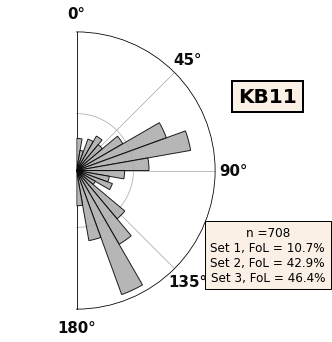

In [16]:
# Plot azimuth rose plot of fracture traces and branches
azimuth_bin_dict, fig, ax = kb11_network.plot_trace_azimuth()

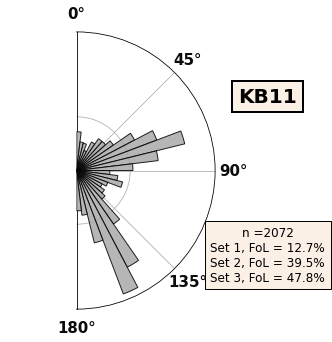

In [17]:
# Plot azimuth rose plot of fracture branches
azimuth_bin_dict, fig, ax = kb11_network.plot_branch_azimuth()

## Topological Fracture Network Characterization

The determination of branches and nodes are essential for characterizing the topology of a fracture network. The topology is the collection of properties of the traces that do not change when the traces are transformed continously i.e. the traces are not cut but are extended or shrinked. In geological terms the traces can go through ductile transformation without losing their topological properties but not brittle transformation. Furthermore this means the end topology of the traces is a result of brittle transformation(s).

At its simplest the proportion of different types of branches and nodes are used to characterize the topology.

Branches can be categorized into three main categories:

-  **C–C** is connected at both endpoints
    
-  **C-I** is connected at one endpoint

-  **I-I** is not connected at either endpoint
    
Nodes can be similarly categorized into three categories:

-  **X** represents intersection between two traces
    
-  **Y** represents abutment of one trace to another
    
-  **I** represents isolated termination of a trace

Furthermore **E** node and any **E**-containing branch classification (e.g. **I-E**) are related to the trace area boundary. Branches are always cropped to the boundary and branches that are cut then have a **E** node as end endpoint.

### Node and branch proportions

The proportion of the different types of nodes and branches have direct implications for the overall connectivity of a fracture network (Sanderson and Nixon 2015).

The proportions are plotted on ternary plots. The plotting uses [python-ternary](https://github.com/marcharper/python-ternary).

In [18]:
kb11_network.node_counts

{'X': 270, 'Y': 824, 'I': 478, 'E': 114}

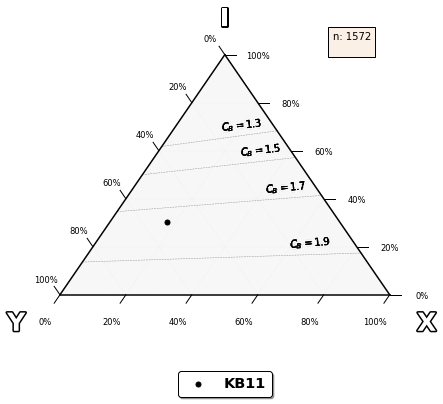

In [19]:
# Plot ternary XYI-node proportion plot
fig, ax, tax = kb11_network.plot_xyi()

In [20]:
kb11_network.branch_counts

{'C - C': 1521,
 'C - I': 410,
 'I - I': 28,
 'C - E': 100,
 'I - E': 12,
 'E - E': 1}

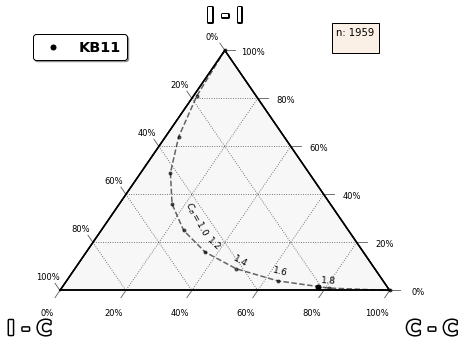

In [21]:
# Plot ternary branch (C-C, C-I, I-I) proportion plot
fig, ax, tax = kb11_network.plot_branch()

### Crosscutting and abutting relationships

If the geometry and topology of the fracture network are investigated together the cross-cutting and abutting relationships between orientation-binned fracture sets can be determined. Traces can be binned into sets based on their orientation (e.g. N-S oriented traces could belong to Set 1 and E-W oriented traces to Set 2). If the endpoints of the traces of sets are examined the abutment relationship between can be determined i.e. which abuts in which (e.g. does the N-S oriented Set 1 traces abut to E-W oriented Set 2 or do they crosscut each other equal amounts.)

In [22]:
# Sets are defaults
print(f"Azimuth set names: {kb11_network.azimuth_set_names}")
print(f"Azimuth set ranges: {kb11_network.azimuth_set_ranges}")

Azimuth set names: ('1', '2', '3')
Azimuth set ranges: ((0, 60), (60, 120), (120, 180))


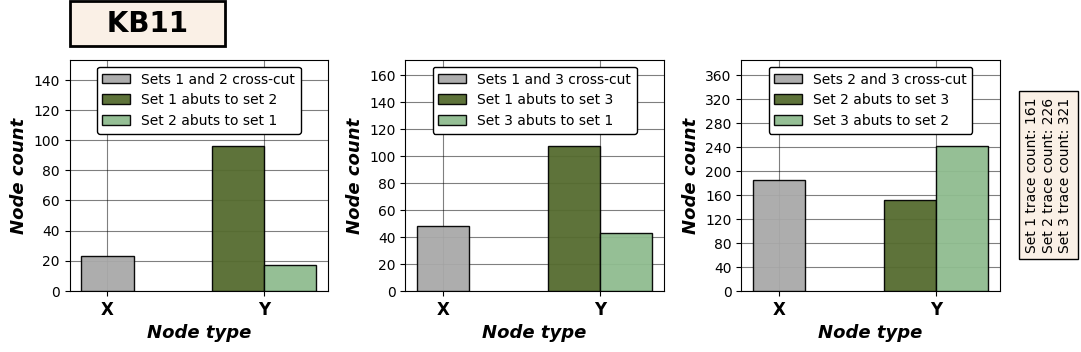

In [23]:
# Plot crosscutting and abutting relationships between azimuth sets
figs, fig_axes = kb11_network.plot_azimuth_crosscut_abutting_relationships()

## Numerical Fracture Network Characterization Parameters

The quantity, total length and other properties of the traces, branches and nodes within the target area can be determined as numerical values. For the following parameters I refer you to the following articles:

-  [Mauldon et al. 2001](https://doi.org/10.1016/S0191-8141(00)00094-8)
-  [Sanderson and Nixon 2015](https://doi.org/10.1016/j.jsg.2015.01.005)

In [24]:
kb11_network.parameters

{'Number of Traces': 651.0,
 'Number of Branches': 2015.0,
 'Fracture Intensity B21': 1.2633728710290455,
 'Fracture Intensity P21': 1.2633728710290455,
 'Areal Frequency P20': 0.5258904658323919,
 'Areal Frequency B20': 1.627756203766927,
 'Trace Mean Length': 2.208940309504849,
 'Branch Mean Length': 0.7761437911312323,
 'Dimensionless Intensity P22': 2.7907152607509293,
 'Dimensionless Intensity B22': 0.9805590097328328,
 'Connections per Trace': 3.3609831029185866,
 'Connections per Branch': 1.7627791563275435,
 'Fracture Intensity (Mauldon)': 1.4357438039436288,
 'Fracture Density (Mauldon)': 0.5258904658323919,
 'Trace Mean Length (Mauldon)': 2.7301194777720483,
 'Connection Frequency': 0.8837544848243267}